In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()
import datetime as dt
import scipy as sp

#import statsmodels.tsa.api as smt
#import statsmodels.api as sm
#from itertools import product
import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

from random import randrange,randint 

from scipy.optimize import curve_fit
import math as math

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
#from sklearn.linear_model import LinearRegression

In [2]:
file_path = '../../data/external/MERGE_1_millet_weather_merge_inner_2014.csv'

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

In [3]:
file = pd.read_csv(file_path)
#file.head(50).transpose()

In [4]:
min_w = 18
max_w = 42
file.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,31878,NaN,NaN,NaN,470.678,304.072,1,218,441,688,1104
KEY,31878,693,uuid:80517f33-f3d0-4960-98b6-d238332a50e2,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ID_menage,31878,NaN,NaN,NaN,4.60899e+39,2.54798e+39,1.84e+36,2.5e+39,4.57e+39,6.49e+39,9.94e+39
crops_cult4,31878,1,Millet,31878,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season_cult4,31878,NaN,NaN,NaN,1.04762,0.297732,1,1,1,1,3
Area planted,31878,NaN,NaN,NaN,2.28732,1.94876,0.01,1,2,3,16
Quantity produced (Kg),31878,NaN,NaN,NaN,1396.27,2031.06,2,350,850,1700,21000
Yield,31878,NaN,NaN,NaN,0.640091,0.85567,0.0004,0.25,0.5,0.8,15
Department,31878,18,NIORO,6486,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Counties,31878,104,MEDINA-SABAKH,1058,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Key, #number of occurences dictionary
dict_keys = {}
unique_keys = file["KEY"].unique()
print(len(unique_keys))

for k in unique_keys:
    if k not in dict_keys:
       dict_keys[k] = 1 
    else:
        dict_keys[k] += 1

for value in dict_keys.values():
    if value != 1:
        warnings.warn("This key occured more than once!")

693


In [6]:
list_of_ndvi_arrays = []
list_of_yields = []
list_of_keys = []
list_of_ndvi_indices = []
list_of_subset_ndvi = []
list_of_subset_pr = []

for i in range(len(unique_keys)):
    k = unique_keys[i]
    selected_subset_df = file.loc[file["KEY"] == k]
    current_ndvi_array = selected_subset_df['ndvi'].to_numpy()
    contains_nan_ndvi = np.isnan(np.min(current_ndvi_array))
    if contains_nan_ndvi:
        print("There is nan value for key: {}. Skipping this one...".format(k))
        continue 
    current_yield = selected_subset_df['Yield'].unique()
    if len(current_yield) != 1:
        warnings.warn("Yield for this key is not same for all!")
    #current_yield[current_yield == -np.inf] = np.nan()
    if np.isnan(current_yield[0]):
        print("Nan yield for key: {}. Skipping this one...".format(k))
        continue
    current_ndvi_index_array = selected_subset_df['nth_8days'].to_numpy()
    
    current_subset_ndvi = current_ndvi_array[min_w:max_w]
    current_subset_pr =  (selected_subset_df['pr'].to_numpy())[min_w:max_w]
    
    list_of_ndvi_arrays.append(current_ndvi_array)     
    list_of_ndvi_indices.append(current_ndvi_index_array)
    list_of_yields.append(current_yield[0])
    list_of_keys.append(k)
    list_of_subset_ndvi.append(current_subset_ndvi)
    list_of_subset_pr.append(current_subset_pr)
    
    #if k == 'uuid:79121b79-066d-4c64-9df0-78785aa48882':
    #    print('It is here...')
    
    
max_fit_ndvi_list = [-1] * len(list_of_ndvi_arrays)
fit_r2_list = [-1] * len(list_of_ndvi_arrays)
max_ndvi_list = [-1] * len(list_of_ndvi_arrays)

df = pd.DataFrame({'KEY': list_of_keys, 'ndvi': list_of_ndvi_arrays, 'nth_8days': list_of_ndvi_indices,
                   'Yield': list_of_yields,'max_ndvi': max_ndvi_list  ,'max_fit_ndvi': max_fit_ndvi_list, 
                   'fit_r2': fit_r2_list,
                  'ndvi_window': list_of_subset_ndvi, 'pr_window': list_of_subset_pr})
#print(df.head(10))

There is nan value for key: uuid:78084537-d066-41a7-a977-7153b945cb8e. Skipping this one...


In [7]:
def fourier_curve(x, a0, a1, b1, a2, b2, omega):
  return a0 + a1*np.cos(x*omega*2*math.pi) + b1*np.sin(x*omega*2*math.pi) + a2*np.cos(x*omega*math.pi*4) + b2*np.sin(x*omega*math.pi*4)

In [8]:
def choose_week_window_ndvi(df_element, min_week=0, max_week=46):
    ndvi = df_element['ndvi']
    ndvi = ndvi[min_week:max_week]
    t = np.array(range(len(ndvi)))
    return ndvi, t

def fit_ndvi_curve(current_ndvi, t_index):
    #para_bounds=[[-1, -1, -1, -1, -1, -10], [1, 1, 1, 1, 1, 10], ]
    #popt, _ = curve_fit(fourier_curve, t_index, current_ndvi, bounds = para_bounds, maxfev=10000)
    popt, _ = curve_fit(fourier_curve, t_index, current_ndvi, maxfev=10000)
    a0, a1, b1, a2, b2, omega = popt
    #print("Parameters: a0 {0}, a1 {1}, b1 {2}, a2 {3}, b2 {4}, omega {5}".format(a0, a1, b1, a2, b2, omega))
    fitted_curve  = fourier_curve(t_index, a0, a1, b1, a2, b2, omega)
    max_curve = max(fitted_curve)
    #plt.plot(t_index, fitted_curve)
    return fitted_curve, max_curve

In [9]:
def recursive_fit(current_ndvi, fitted_ndvi, t_index, max_iteration = 5):
    count = 0
    while count < max_iteration:
        for x in range(len(current_ndvi)):
            if current_ndvi[x] < fitted_ndvi[x]:
                current_ndvi[x] = fitted_ndvi[x]
        # Fit again... 
        fitted_curve, max_curve = fit_ndvi_curve(current_ndvi, t_index)
        count += 1 
    return fitted_curve, max_curve

In [10]:
#def r_squared(y, y_fit):
#    # Residual sum of squares
#    ss_res = np.sum((y - y_fit) ** 2)
#
#    # Total sum of squares
#    ss_tot = np.sum((y - np.mean(y)) ** 2)
#
#    # r-squared
#    r2 = 1 - (ss_res / ss_tot)
#    return r2    

# plot some of the ndvi values, this is not working with the fitted yet
def plot_ndvis(df_element, min_week=0, max_week=46, fitted_curve=None, index_fitted_curve=None):
    fig = plt.figure(figsize=(4,4))
    nth_8days = df_element['nth_8days']
    ndvi = df_element['ndvi']
    plt.plot(nth_8days[min_week:max_week] , ndvi[min_week:max_week])
    if fitted_curve!= None:
        print(fitted_curve)
        plt.plot(index_fitted_curve, fitted_curve)
    plt.ylabel('NDVI')
    plt.xlabel('Nth 8 days')
    plt.title('Key: {}'.format(df_element['KEY']), fontsize=8)

def plot_ndvi_fits(ndvi, fitted_curve, index):
    fig = plt.figure(figsize=(4,4))
    plt.plot(index, ndvi)
    plt.plot(index, fitted_curve)
    plt.ylabel('NDVI')
    r2 = r2_score(ndvi, fitted_curve)
    plt.title("R2 = {}".format(r2))

In [11]:
#current_ndvi, t_index = choose_week_window_ndvi(df.loc[0], min_week=min_w, max_week=max_w)

In [12]:
ndvi_fit_list = []
for element in range(df.shape[0]):   
    #print(df.loc[element])
    current_ndvi, t_index = choose_week_window_ndvi(df.loc[element], min_week=min_w, max_week=max_w)
    if element == 128:
        df.loc[element, 'max_fit_ndvi'] = 1
        ndvi_fit_list.append(current_ndvi)
        continue
    fitted_curve, max_curve = fit_ndvi_curve(current_ndvi, t_index)
    fitted_curve, max_curve = recursive_fit(current_ndvi, fitted_curve, t_index, 3)
    #fitted_curve, max_curve = current_ndvi, max(current_ndvi)
    if r2_score(current_ndvi, fitted_curve) < 0.8:
        df.loc[element, 'fit_r2'] = -1.0
        df.loc[element, 'max_fit_ndvi'] = max(current_ndvi)
        ndvi_fit_list.append(current_ndvi)
    else:
        df.loc[element, 'fit_r2'] = r2_score(current_ndvi, fitted_curve)
        df.loc[element, 'max_fit_ndvi'] = max_curve
        ndvi_fit_list.append(fitted_curve)
    df.loc[element, 'max_ndvi'] = max(current_ndvi)
    #df.loc[element, 'ndvi_fit'] = fitted_curve
    #plot_ndvi_fits(current_ndvi, fitted_curve, t_index) 
df['ndvi_fit'] = ndvi_fit_list  

In [13]:
df.replace(-np.inf, np.nan, inplace=True)
df.replace(np.inf, np.nan, inplace=True)
df.dropna(inplace=True)
df.describe(include='all')

,KEY,ndvi,nth_8days,Yield,max_ndvi,max_fit_ndvi,fit_r2,ndvi_window,pr_window,ndvi_fit
count,692,692,692,692.000000,692.000000,692.000000,692.000000,692,692,692
unique,692,692,692,NaN,NaN,NaN,NaN,692,692,692
top,uuid:80517f33-f3d0-4960-98b6-d238332a50e2,"[0.33433234691619873, 0.3332195281982422, 0.31...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",NaN,NaN,NaN,NaN,"[0.22081990540027616, 0.22553209395423304, 0.2...","[0.10125, 0.0025, 0.0975, 0.01375, 0.11375, 0....","[0.2224173471230264, 0.23421735630371382, 0.24..."
freq,1,1,1,NaN,NaN,NaN,NaN,1,1,1
mean,NaN,NaN,NaN,0.640245,0.642470,0.628446,0.621065,NaN,NaN,NaN
std,NaN,NaN,NaN,0.856884,0.120458,0.101979,0.733090,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000400,-1.000000,0.289098,-1.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,0.250000,0.633176,0.607392,0.884171,NaN,NaN,NaN
50%,NaN,NaN,NaN,0.500000,0.661802,0.649398,0.958335,NaN,NaN,NaN
75%,NaN,NaN,NaN,0.800000,0.713537,0.695257,0.987153,NaN,NaN,NaN


In [14]:
dataset_size = df.shape[0]
print(dataset_size)

training_size =  int(dataset_size * 0.70)
validation_size = int(dataset_size * 0.15)

training_set = df[:training_size].reset_index(drop=True)
validation_set = df[training_size:training_size+validation_size].reset_index(drop=True)
test_set = df[training_size+validation_size:].reset_index(drop=True)
test_size = len(test_set)

print(training_set)

print(training_set.shape)
print(validation_set.shape)
print(test_set.shape)

692
                                           KEY  \
0    uuid:000a83ec-a8df-4439-bb6c-77cf4d6439e5   
1    uuid:000be421-3444-486e-8d1c-23514be2cbde   
2    uuid:00b0e565-1670-4b4e-9deb-f41c78b107ec   
3    uuid:00bb29a9-7f59-45c9-8f54-d7b577599d89   
4    uuid:00dee809-f770-421d-b013-f84427d7db08   
..                                         ...   
479  uuid:8bdf374e-47f8-4971-bf7f-5dbd07adaae9   
480  uuid:8bf932e8-e91f-4ef4-8f52-a0cab81c6552   
481  uuid:8d1ae37a-e871-4a77-879f-3cc2cab2ffac   
482  uuid:8dddeccc-cc56-4a54-83b4-4f6f463396d3   
483  uuid:8de06fd4-dde3-43ca-bfe6-ef4a01b16bdc   

                                                  ndvi  \
0    [0.3041703701019287, 0.2963317334651947, 0.288...   
1    [0.4123587608337401, 0.4080786108970642, 0.393...   
2    [0.3934859037399292, 0.3985716998577118, 0.386...   
3    [0.3842112421989441, 0.3615646362304688, 0.354...   
4    [0.32235175371170044, 0.3126063644886017, 0.30...   
..                                             

In [15]:
import tensorflow as tf

In [16]:
print(tf.__version__)

2.4.0


In [17]:
batch_size = 1 # need to increase this... 

# Here goes the DNN/LSTM model and training
tf.random.set_seed(51)
np.random.seed(51)

In [18]:
training_set = training_set.loc[training_set['Yield']<3.0].reset_index(drop=True)

In [19]:
validation_set = validation_set.loc[validation_set['Yield']<3.0].reset_index(drop=True)

In [20]:
def crop_scatter_matrix(df, columns = ['max_ndvi', 'sum_ndvi', 'Yield']):   
    columns = ['max_ndvi', 'sum_ndvi', 'Yield']
    pd.plotting.scatter_matrix(df, figsize = (6,6), diagonal='kde')

    print('Pearson corr (linear):')
    print(df.corr(method='pearson'))

    print('Spearman corr (monotonic):')
    print(df.corr(method='spearman'))
    
    print('Kendal corr (monotonic):')
    print(df.corr(method='kendall'))
    return df

Pearson corr (linear):
                 Yield  max_ndvi  max_fit_ndvi    fit_r2
Yield         1.000000  0.170869      0.175653  0.096341
max_ndvi      0.170869  1.000000      0.710672  0.285441
max_fit_ndvi  0.175653  0.710672      1.000000  0.204045
fit_r2        0.096341  0.285441      0.204045  1.000000
Spearman corr (monotonic):
                 Yield  max_ndvi  max_fit_ndvi    fit_r2
Yield         1.000000  0.156534      0.163572  0.192716
max_ndvi      0.156534  1.000000      0.946523 -0.023819
max_fit_ndvi  0.163572  0.946523      1.000000 -0.002195
fit_r2        0.192716 -0.023819     -0.002195  1.000000
Kendal corr (monotonic):
                 Yield  max_ndvi  max_fit_ndvi    fit_r2
Yield         1.000000  0.104527      0.109427  0.134117
max_ndvi      0.104527  1.000000      0.833958 -0.010937
max_fit_ndvi  0.109427  0.833958      1.000000  0.008811
fit_r2        0.134117 -0.010937      0.008811  1.000000


,KEY,ndvi,nth_8days,Yield,max_ndvi,max_fit_ndvi,fit_r2,ndvi_window,pr_window,ndvi_fit
0,uuid:000a83ec-a8df-4439-bb6c-77cf4d6439e5,"[0.3041703701019287, 0.2963317334651947, 0.288...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.280000,0.673966,0.655555,0.991496,"[0.21494209958738333, 0.2087620572417811, 0.20...","[0.035, 0.00375, 0.0025, 0.013749999999999998,...","[0.22011748517436794, 0.21092390744494302, 0.2..."
1,uuid:000be421-3444-486e-8d1c-23514be2cbde,"[0.4123587608337401, 0.4080786108970642, 0.393...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.006250,0.626266,0.607392,0.956269,"[0.31410340972314543, 0.29304500764309616, 0.2...","[0.16125, 0.0075, 0.0675, 0.01625, 0.10875, 0....","[0.31698488806479475, 0.29908944168051654, 0.2..."
2,uuid:00b0e565-1670-4b4e-9deb-f41c78b107ec,"[0.3934859037399292, 0.3985716998577118, 0.386...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.025000,0.334198,0.337863,0.920326,"[0.19771552085876465, 0.19548109228474075, 0.1...","[0.0, 0.0, 0.0, 0.00625, 0.02125, 0.02, 0.0375...","[0.19722854288329472, 0.19995972577248455, 0.2..."
3,uuid:00dee809-f770-421d-b013-f84427d7db08,"[0.32235175371170044, 0.3126063644886017, 0.30...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.900000,0.672366,0.662829,0.994370,"[0.22682932430629463, 0.2207872007215058, 0.21...","[0.03, 0.00125, 0.00125, 0.01125, 0.1475000000...","[0.23083567428048235, 0.22285430774614765, 0.2..."
4,uuid:016476e7-f902-4866-b9af-f78bb26b8e3d,"[0.3422392010688782, 0.3186202347278595, 0.315...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1.300000,0.755312,0.755312,-1.000000,"[0.34153197167339044, 0.358270525932312, 0.388...","[0.035, 0.06375, 0.015, 0.037500000000000006, ...","[0.34153197167339044, 0.358270525932312, 0.388..."
...,...,...,...,...,...,...,...,...,...,...
473,uuid:8bdf374e-47f8-4971-bf7f-5dbd07adaae9,"[0.21514925360679624, 0.2117542773485184, 0.21...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.028571,0.363007,0.377768,0.807550,"[0.19321683550606394, 0.2004772178776258, 0.20...","[0.00125, 0.0, 0.0, 0.00375, 0.06375, 0.052500...","[0.21257388111826003, 0.21975573500521692, 0.2..."
474,uuid:8bf932e8-e91f-4ef4-8f52-a0cab81c6552,"[0.2749326229095459, 0.2684869468212128, 0.258...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.750000,0.633099,0.624564,0.980638,"[0.20864634818561742, 0.19961998154386906, 0.1...","[0.0325, 0.00125, 0.0, 0.0025, 0.0775, 0.0775,...","[0.2188851660378225, 0.20872196657195663, 0.19..."
475,uuid:8d1ae37a-e871-4a77-879f-3cc2cab2ffac,"[0.440447598695755, 0.4436562061309815, 0.4283...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.400000,0.636746,0.648309,0.936042,"[0.36829338619410584, 0.3774561128132384, 0.40...","[0.052500000000000005, 0.01375, 0.09125, 0.012...","[0.3749596071444006, 0.38481114007777006, 0.39..."
476,uuid:8dddeccc-cc56-4a54-83b4-4f6f463396d3,"[0.3679123222827912, 0.3441331386566162, 0.336...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0.533333,0.751315,0.751315,-1.000000,"[0.40204700490311646, 0.43874207139015203, 0.4...","[0.035, 0.02875, 0.0325, 0.01875, 0.11625, 0.0...","[0.40204700490311646, 0.43874207139015203, 0.4..."


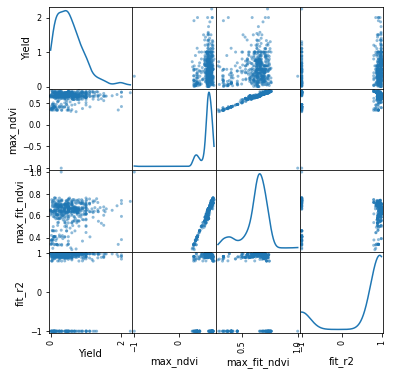

In [21]:
crop_scatter_matrix(training_set)

max_ndvi or max_fit_ndvi are not correlated to the yield at all. so do not try that single variable approach at all here. 

In [22]:
def select_features_from_arrays(df, list_columns=['ndvi_window', 'pr_window']):    
    train_features = []
    
    for x in range(df.shape[0]):
        features = []
        col_0 = df.loc[x,list_columns[0]]  
        if len(list_columns)>1:
            col_1 = df.loc[x,list_columns[1]]
            col_0 = np.concatenate((col_0, col_1), axis=0)
        #print(col_0)
        train_features.append(col_0)    
        #print(train_features)

    #(a==train_features).all()    
    return train_features   

In [23]:
def predict_yield(input_features, model):
    predicted_yield = []
    for x in range(len(input_features)):
        predicted_yield.append(model.predict(input_features[x][np.newaxis]))

    #print(predicted_yield)
    results = np.array(predicted_yield)[:, 0, 0]
    print(results)
    return results

In [24]:
def evaluate_regression(yield_array, yield_pred):
    err = np.abs(yield_array - yield_pred)/(yield_array) * 100

    plt.figure()      
    #plt.plot(yield_array, color='b', label='Training set, truth', marker = 'o', linestyle='None', markersize = 5.0)
    #plt.plot(yield_pred, color='r', label='Training set, pred',  marker = 'o', linestyle='None', markersize = 5.0)
    plt.plot(yield_array, color='b', label='Training set, truth', marker = 'o', linestyle='dotted', markersize = 5.0)
    plt.plot(yield_pred, color='r', label='Training set, pred',  marker = 'o', linestyle='dotted', markersize = 5.0)

    plt.ylabel('Yield')
    plt.legend(loc='best')
    
    plt.figure()      
    plt.scatter(yield_array, err)
    plt.xlabel('True yield')
    plt.ylabel('Error (abs, percentage)')
    
    print("Mean absolute percantage error: {}".format(mean_absolute_percentage_error(yield_array, yield_pred)))
    #plt.ylim(0,100)

Training using the raw NDVI and rainfall windows (24 * 2 = 48 inputs)

In [25]:
training_features = select_features_from_arrays(training_set)
validation_features = select_features_from_arrays(validation_set)
test_features = select_features_from_arrays(test_set)

pre_mean = np.mean(training_features, axis=0)
print(pre_mean)
training_features -= pre_mean
pre_std = np.std(training_features, axis=0)
training_features /= pre_std

validation_features -= pre_mean
validation_features /= pre_std


test_features -= pre_mean
test_features -= pre_std

[2.64654378e-01 2.68695207e-01 2.73172173e-01 2.79968704e-01
 2.75419648e-01 2.82659969e-01 2.99983104e-01 3.09251716e-01
 3.38972956e-01 3.23453033e-01 3.71672159e-01 4.03798144e-01
 4.69351422e-01 5.22762785e-01 5.40453392e-01 5.87141959e-01
 5.96883233e-01 6.14609100e-01 5.83741046e-01 5.47269902e-01
 5.04474370e-01 4.74975320e-01 4.62213415e-01 4.43540900e-01
 4.39199791e-02 1.23561715e-02 1.47960251e-02 1.22960251e-02
 1.07225418e-01 8.88755230e-02 8.92939331e-02 9.47960251e-02
 1.75802824e-01 2.71835774e-01 4.91584728e-01 3.01976987e-01
 1.76501046e-01 2.41495816e-01 3.44691423e-01 1.11895921e-01
 2.05758368e-01 7.33734310e-02 3.26229079e-02 3.06956067e-02
 1.29811715e-02 5.23012552e-06 6.87761506e-04 6.67102510e-03]


In [26]:
training_TF = tf.data.Dataset.from_tensor_slices( ( training_features, training_set.Yield) ) 

In [27]:
training_TF = training_TF.shuffle(training_size).batch(batch_size)
#for element in training_TF:
#    for each in element:
#        print(each.numpy())
#    print('next')

In [28]:
#validation_TF = tf.data.Dataset.from_tensor_slices((validation_set.ndvi, validation_set.Yield))
validation_TF = tf.data.Dataset.from_tensor_slices((validation_features, validation_set.Yield))
validation_TF = validation_TF.shuffle(validation_size).batch(batch_size)

In [29]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, input_shape=[48], activation="relu"), 
    tf.keras.layers.Dense(50, activation="relu"), 
    tf.keras.layers.Dense(1, activation="linear")
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-10, beta_1=0.9)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2450      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 5,051
Trainable params: 5,051
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(training_TF, validation_data = validation_TF, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
478/478 [==============================] - 3s 4ms/step - loss: 0.5296 - val_loss: 0.6699
Epoch 2/100
478/478 [==============================] - 1s 2ms/step - loss: 0.5382 - val_loss: 0.6689
Epoch 3/100
478/478 [==============================] - 1s 2ms/step - loss: 0.5730 - val_loss: 0.6678
Epoch 4/100
478/478 [==============================] - 1s 2ms/step - loss: 0.5499 - val_loss: 0.6666
Epoch 5/100
478/478 [==============================] - 1s 2ms/step - loss: 0.6117 - val_loss: 0.6652
Epoch 6/100
478/478 [==============================] - 1s 2ms/step - loss: 0.5356 - val_loss: 0.6636
Epoch 7/100
478/478 [==============================] - 1s 2ms/step - loss: 0.5914 - val_loss: 0.6618
Epoch 8/100
478/478 [==============================] - 1s 2ms/step - loss: 0.5149 - val_loss: 0.6599
Epoch 9/100
478/478 [==============================] - 1s 2ms/step - loss: 0.5267 - val_loss: 0.6576
Epoch 10/100
478/478 [==============================] - 1s 2ms/step - loss: 0.5708 - val_lo

478/478 [==============================] - 1s 2ms/step - loss: 0.1355 - val_loss: 0.1888
Epoch 82/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1005 - val_loss: 0.1908
Epoch 83/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1342 - val_loss: 0.1863
Epoch 84/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1229 - val_loss: 0.1970
Epoch 85/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1264 - val_loss: 0.1940
Epoch 86/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1289 - val_loss: 0.1918
Epoch 87/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1145 - val_loss: 0.1960
Epoch 88/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1241 - val_loss: 0.1917
Epoch 89/100
478/478 [==============================] - 1s 3ms/step - loss: 0.1202 - val_loss: 0.1932
Epoch 90/100
478/478 [==============================] - 1s 3ms/step - loss: 0.1185 - val_loss: 

(1e-08, 0.001, 0.0, 1.0)

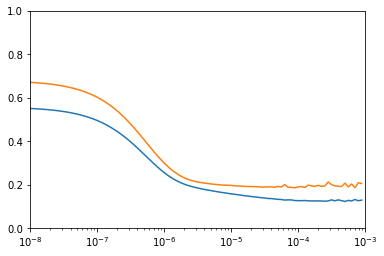

In [31]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.semilogx(lrs, history.history["val_loss"])
plt.axis([1e-8, 1e-3, 0, 1])

In [38]:
tf.keras.backend.clear_session()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dropout(0.1, input_shape=(48,)),
    tf.keras.layers.Dense(50, activation="relu"),  #input_shape=[44],
    tf.keras.layers.Dense(50, activation="relu"), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9)
model.compile(loss="mse", optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2450      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 5,051
Trainable params: 5,051
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model.fit(training_TF, validation_data = validation_TF, epochs=100, verbose=1, callbacks=[early_stop])

Epoch 1/100
478/478 [==============================] - 2s 2ms/step - loss: 0.7189 - val_loss: 0.3682
Epoch 2/100
478/478 [==============================] - 1s 2ms/step - loss: 0.2872 - val_loss: 0.2787
Epoch 3/100
478/478 [==============================] - 1s 2ms/step - loss: 0.2274 - val_loss: 0.2495
Epoch 4/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1975 - val_loss: 0.2359
Epoch 5/100
478/478 [==============================] - 1s 2ms/step - loss: 0.2042 - val_loss: 0.2308
Epoch 6/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1880 - val_loss: 0.2260
Epoch 7/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1890 - val_loss: 0.2210
Epoch 8/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1859 - val_loss: 0.2202
Epoch 9/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1622 - val_loss: 0.2172
Epoch 10/100
478/478 [==============================] - 1s 2ms/step - loss: 0.1982 - val_lo

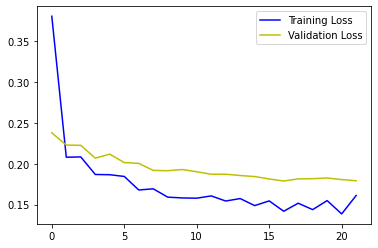

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, color='b', label='Training Loss')
plt.plot(epochs, val_loss, color='y', label='Validation Loss')
plt.legend()
#plt.xlim(40,100)
plt.show()

In [40]:
predicted_yield = predict_yield(validation_features, model)

[0.49457276 0.7644254  0.2752202  0.5041815  0.7652496  0.6496091
 0.5439688  0.76438344 0.61674535 0.60644895 0.6567913  0.64269966
 0.4888963  0.44606364 0.3578434  0.7581442  0.23635577 0.61664474
 0.61816686 0.43111086 0.18614079 0.7872407  0.5426457  0.17999241
 0.6610017  0.5660662  0.2289263  0.23302722 0.57181704 0.80929315
 0.5192887  0.6800382  0.33379114 0.28271002 0.56907344 0.5710919
 0.45537555 0.6346162  0.62797827 0.3344661  0.5604506  0.40102202
 0.53957087 0.6272017  0.537371   0.56772745 0.40046886 0.7269676
 0.4518649  0.7919161  0.8044803  0.6470873  0.714773   0.50363886
 0.5940662  0.7252072  0.79207057 0.6470833  0.7012866  0.46702987
 0.6327402  0.67944515 0.5882228  0.60798573 0.69458956 0.43480796
 0.76969635 0.7360736  0.54238087 0.7071162  0.21264222 0.6304035
 0.5149802  0.65273774 0.5115779  0.07232206 0.8003738  0.41853398
 0.4009912  0.33178538 0.4756896  0.4657755  0.5861953  0.19305582
 0.68011653 0.53555954 0.5383491  0.73803514 0.3986578  0.5936167


Model that used the raw NDVI and rainfall windows (24 * 2 = 48 inputs) to train a feedforward DNN with few hidden layers. 

Mean absolute percantage error: 635.5613984781754


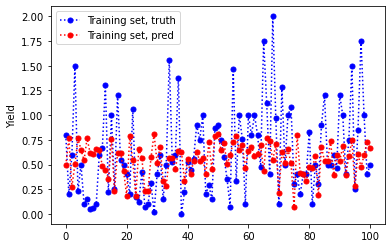

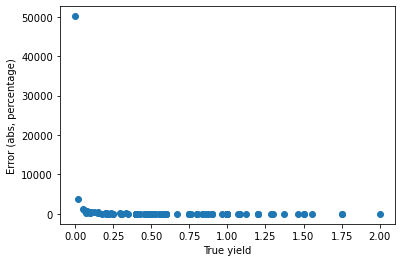

In [41]:
evaluate_regression(validation_set.Yield,predicted_yield)

In [52]:
tf.keras.backend.clear_session()

# Try with the NDVI window only an LSTM 

# Prepare the data
training_features_fitted_ndvi_window = select_features_from_arrays(training_set, ['ndvi_fit'])
validation_features_fitted_ndvi_window = select_features_from_arrays(validation_set, ['ndvi_fit'])
test_features_fitted_ndvi_window = select_features_from_arrays(test_set, ['ndvi_fit'])

#pre_mean_fitted_ndvi_window = np.mean(training_features_fitted_ndvi_window, axis=0)
#print(pre_mean)
#training_features_fitted_ndvi_window -= pre_mean_fitted_ndvi_window
#pre_std_fitted_ndvi_window = np.std(training_features_fitted_ndvi_window, axis=0)
#training_features_fitted_ndvi_window /= pre_std_fitted_ndvi_window

#validation_features_fitted_ndvi_window -= pre_mean_fitted_ndvi_window
#validation_features_fitted_ndvi_window /= pre_std_fitted_ndvi_window


#test_features_fitted_ndvi_window -= pre_mean_fitted_ndvi_window
#test_features_fitted_ndvi_window -= pre_std_fitted_ndvi_window

training_TF_ndvi_window = tf.data.Dataset.from_tensor_slices( ( training_features_fitted_ndvi_window, training_set.Yield) ) 
training_TF_ndvi_window = training_TF_ndvi_window.shuffle(training_size).batch(batch_size)
validation_TF_ndvi_window = tf.data.Dataset.from_tensor_slices((validation_features_fitted_ndvi_window, validation_set.Yield))
validation_TF_ndvi_window = validation_TF_ndvi_window.shuffle(validation_size).batch(batch_size)

Training with fitted NDVI series (24 inputs)

In [53]:
tf.keras.backend.clear_session()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


model_ndvi_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(26, activation="relu", return_sequences=True),  #input_shape=[44],
    tf.keras.layers.LSTM(26, activation="relu"), 
    tf.keras.layers.Dense(1)
])

optimizer_ndvi_LSTM = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model_ndvi_LSTM.compile(loss="mse", optimizer=optimizer_ndvi_LSTM)
model_ndvi_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 26)          2912      
_________________________________________________________________
lstm_1 (LSTM)                (None, 26)                5512      
_________________________________________________________________
dense (Dense)                (None, 1)                 27        
Total params: 8,451
Trainable params: 8,451
Non-trainable params: 0
_________________________________________________________________


In [54]:
history_ndvi_LSTM = model_ndvi_LSTM.fit(training_TF_ndvi_window, validation_data = validation_TF_ndvi_window, epochs=100, verbose=1, callbacks=[early_stop])

Epoch 1/100
478/478 [==============================] - 15s 24ms/step - loss: 0.3835 - val_loss: 0.4754
Epoch 2/100
478/478 [==============================] - 10s 21ms/step - loss: 0.2913 - val_loss: 0.3996
Epoch 3/100
478/478 [==============================] - 9s 18ms/step - loss: 0.2912 - val_loss: 0.3466
Epoch 4/100
478/478 [==============================] - 8s 17ms/step - loss: 0.2182 - val_loss: 0.3101
Epoch 5/100
478/478 [==============================] - 8s 18ms/step - loss: 0.1941 - val_loss: 0.2830
Epoch 6/100
478/478 [==============================] - 9s 18ms/step - loss: 0.1835 - val_loss: 0.2632
Epoch 7/100
478/478 [==============================] - 8s 17ms/step - loss: 0.1699 - val_loss: 0.2487
Epoch 8/100
478/478 [==============================] - 8s 17ms/step - loss: 0.1627 - val_loss: 0.2373
Epoch 9/100
478/478 [==============================] - 8s 17ms/step - loss: 0.1445 - val_loss: 0.2292
Epoch 10/100
478/478 [==============================] - 8s 17ms/step - loss: 0.1

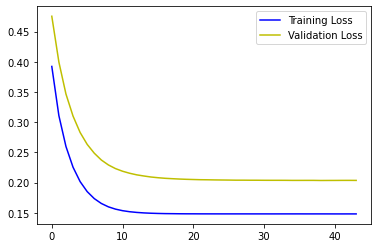

In [55]:
loss = history_ndvi_LSTM.history['loss']
val_loss = history_ndvi_LSTM.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, color='b', label='Training Loss')
plt.plot(epochs, val_loss, color='y', label='Validation Loss')
plt.legend()
#plt.xlim(40,100)
plt.show()

In [56]:
predicted_yield_ndvi_LSTM = predict_yield(validation_features_fitted_ndvi_window, model_ndvi_LSTM)

[0.5430919  0.523733   0.50843346 0.54452485 0.54781723 0.53469235
 0.5314764  0.5478492  0.5446693  0.54030406 0.5349991  0.53423643
 0.53715503 0.524948   0.5472357  0.5523872  0.5154542  0.544678
 0.5352946  0.52455515 0.5527084  0.5446805  0.55079424 0.51451164
 0.5339141  0.52932346 0.51888704 0.5527059  0.53447807 0.54926455
 0.53275585 0.55024254 0.5472678  0.5471375  0.5380011  0.5344914
 0.5372944  0.5340974  0.54591554 0.5472678  0.53127694 0.5381286
 0.55228233 0.5372665  0.5477538  0.52945393 0.539533   0.54190016
 0.5368844  0.55213225 0.54730326 0.53571117 0.53771627 0.5378282
 0.54043597 0.54937184 0.5444467  0.53607166 0.53542167 0.54188085
 0.5372044  0.5501517  0.54790264 0.55044115 0.55247426 0.54173565
 0.53494567 0.5334289  0.53771114 0.5348182  0.54776084 0.5517837
 0.52649415 0.53298855 0.54475933 0.54352534 0.54738486 0.5521952
 0.55233437 0.5440806  0.52625835 0.5378252  0.5479176  0.54990226
 0.5504918  0.55228996 0.55228233 0.53341556 0.5533602  0.53233504
 0

Model with trained with the fitted (2nd order fourier) NDVI series (24 inputs) using a simple LSTM 

Mean absolute percantage error: 566.7252461946993


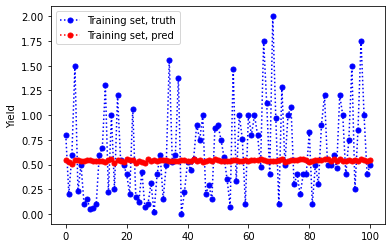

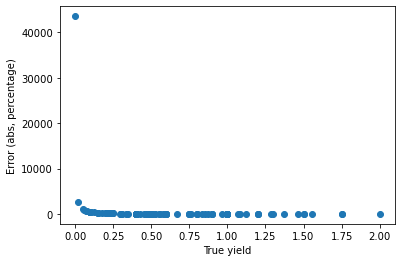

In [57]:
evaluate_regression(validation_set.Yield,predicted_yield_ndvi_LSTM)